## kNN redshift classification of galaxies by their photometry

We will use SDSS data to classify galaxies by their redshift using photometry, labels will come from spectroscopic redshifts from the same catalog.

We will start by making an SQL query to the SDSS database, where will get u,g,r,i and z bands. We will also get the spectroscopic redshift and class. In this case we have objects that are classified as galaxies and quasars, for the moment we will use both.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from astroquery.sdss import SDSS
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

/home/daniela/anaconda3/envs/DSFP/lib/python3.6/site-packages/astroquery/sdss/__init__.py:29: UserWarning: Experimental: SDSS has not yet been refactored to have its API match the rest of astroquery (but it's nearly there).
  warnings.warn("Experimental: SDSS has not yet been refactored to have its API "


In [3]:
#Getting data from astropy

sdss_query = ''' SELECT TOP 100000
           p.modelMag_u, p.modelMag_g, p.modelMag_r, p.modelMag_i, p.modelMag_z,
           s.class, s.z
           FROM PhotoObjAll AS p JOIN specObjAll s ON s.bestobjid = p.objid
           WHERE p.mode = 1 AND s.sciencePrimary = 1 AND p.clean = 1 AND s.class != 'STAR'
           ORDER BY p.objid ASC
             '''
phot_z = SDSS.query_sql(sdss_query)

/home/daniela/anaconda3/envs/DSFP/lib/python3.6/site-packages/astroquery/sdss/core.py:856: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  comments='#'))


In [4]:
#Turn astroquery table to pandas table

photo_z = phot_z.to_pandas()

In [5]:
# First look at the table
photo_z

,modelMag_u,modelMag_g,modelMag_r,modelMag_i,modelMag_z,class,z
0,19.41061,18.23754,17.58132,17.20153,16.90159,b'GALAXY',0.032125
1,20.98014,20.28274,19.35493,18.85322,18.44382,b'GALAXY',0.200468
2,25.26718,22.31524,21.31751,19.93510,19.45918,b'GALAXY',0.752706
3,22.66974,22.00222,20.39819,19.57147,19.20231,b'GALAXY',0.504672
4,21.43851,18.80143,17.69470,17.19680,16.80610,b'GALAXY',0.110611
5,23.00731,21.34087,19.74872,19.14171,18.80783,b'GALAXY',0.293778
6,19.80807,18.33917,17.63962,17.24621,17.00000,b'GALAXY',0.074298
7,19.54964,17.95799,17.02898,16.53100,16.13408,b'GALAXY',0.121315
8,18.74425,17.37778,16.80538,16.51149,16.28756,b'GALAXY',0.048765
9,21.17984,19.97005,19.44376,19.11705,19.06998,b'GALAXY',0.048808


In [6]:
# Shape of table
photo_z.shape

(100000, 7)

The first thing we want to do, is take a look at the distribution of redshift of our data. The results in classification will strongly depend on how well sampled is our parameter space.

Text(0.5, 1.0, 'Histogram (Log scale)')

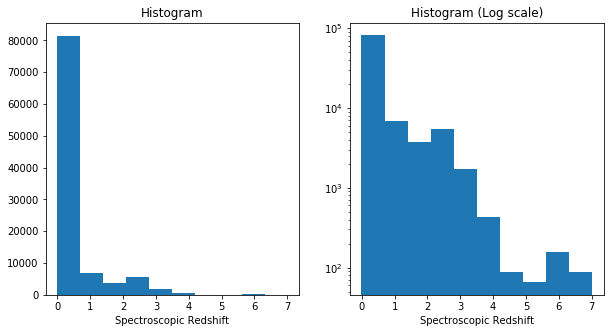

In [7]:
fig, ax = plt.subplots(figsize = (10,5), ncols = 2)

ax[0].hist(photo_z.z)
ax[0].set_xlabel('Spectroscopic Redshift')
ax[0].set_title('Histogram')

ax[1].hist(photo_z.z)
ax[1].set_yscale('log')
ax[1].set_xlabel('Spectroscopic Redshift')
ax[1].set_title('Histogram (Log scale)')

In [8]:
# Proportion of sources with z < 1

z_l1 = len(photo_z.query('z <= 1')) / len(photo_z) * 100

print('The proportion of sources with z < 1 is {}'.format(z_l1))

The proportion of sources with z < 1 is 85.962


Although the amount of sources at $z > 1 $ is low, we will try and make the regression for all the sources, as a test. Now we will start by creating a training and testing sample, for both the features and the classes. We will use a third of our data to test our regressors.

In [9]:
# Separate features and classes

X = photo_z.iloc[:,:-2]
y = photo_z.z

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

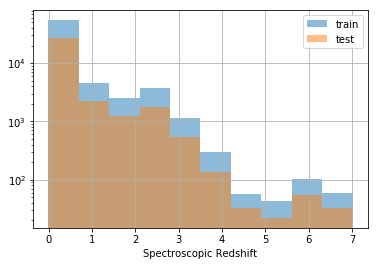

In [10]:
# Distribution of classes for both the testing a training sets

y_train.hist(alpha = 0.5, label = 'train')
y_test.hist(alpha = 0.5, label = 'test')
plt.xlabel('Spectroscopic Redshift')
plt.yscale('log')

plt.legend()

Now we can start training our regressor, we will choose the K Nearest Neighbors Algorithm to start with. 

In [11]:
# Training a Regressor

knn_r = KNeighborsRegressor(n_neighbors=3)
knn_r.fit(X_train, y_train) 

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=None, n_neighbors=3, p=2,
          weights='uniform')

In [12]:
# Predict

y_predict_r = knn_r.predict(X_test)

[]

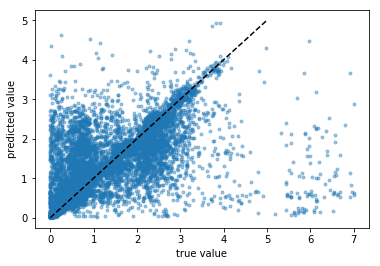

In [13]:
plt.scatter(y_test, y_predict_r, marker = '.', alpha = 0.4)
plt.plot([0,5],[0,5], 'k--')
plt.xlabel('true value')
plt.ylabel('predicted value')
plt.plot()

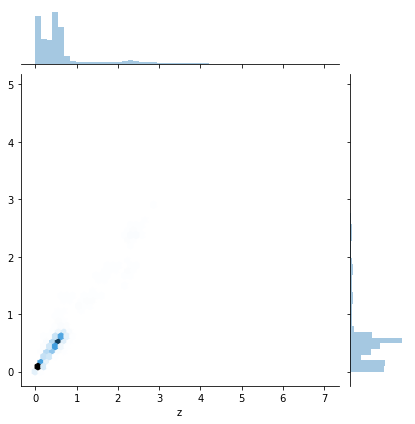

In [14]:
sns.jointplot(y_test, y_predict_r, kind="hex")

In [15]:
mean_squared_error(y_test, y_predict_r)

0.25711245603498684

In [16]:
# Optimizing number of neighbors based on mean squared error

def get_acc(k, X_train, y_train, X_test, y_test):
    knn = KNeighborsRegressor(n_neighbors=k)
    knn.fit(X_train, y_train) 
    y_predict = knn.predict(X_test)
    
    return mean_squared_error(y_test, y_predict)

X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.33, random_state=42)

neighbors = np.arange(2,40,1)
accuracy = []
for n in neighbors:
    accuracy.append(get_acc(n, X_tr, y_tr, X_te, y_te))

The optimal number of neighbors is 25


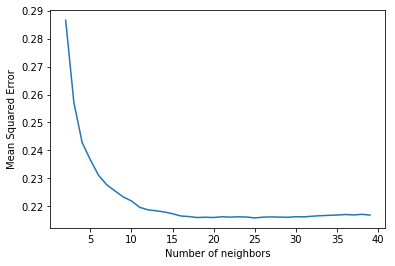

In [17]:
# Plot results from tuning

plt.plot(neighbors, accuracy)
plt.xlabel('Number of neighbors')
plt.ylabel('Mean Squared Error')
print('The optimal number of neighbors is {}'.format(neighbors[np.argmin(accuracy)]))

Mean Squared Error is 0.21580473969810499


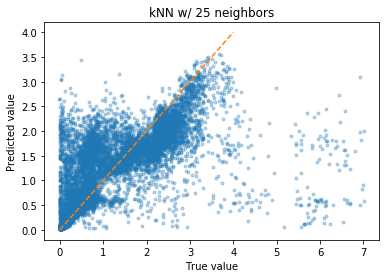

In [18]:
# Re-run for the optimal

knn10 = KNeighborsRegressor(n_neighbors=25)
knn10.fit(X_tr, y_tr) 
y_pr = knn10.predict(X_te)
mse = mean_squared_error(y_te, y_pr)


plt.plot(y_te, y_pr, '.', alpha = 0.3)
plt.plot([0,4],[0,4], '--')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('kNN w/ 25 neighbors')
plt.plot()
print('Mean Squared Error is {}'.format(mse))

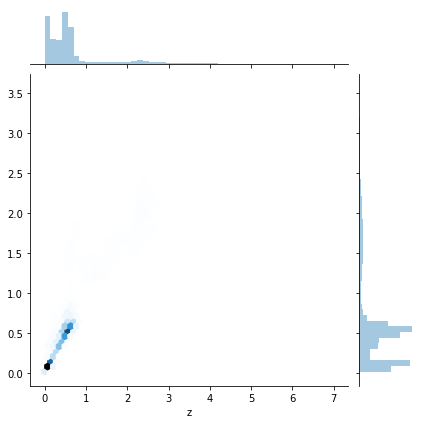

In [19]:
sns.jointplot(y_te, y_pr, kind="hex")

Text(0.5, 0, 'True redshift - Predicted redshift')

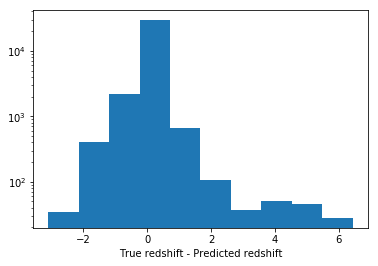

In [20]:
plt.hist(y_te - y_pr)
plt.yscale('log')
plt.xlabel('True redshift - Predicted redshift')

We can see that there are a lot of sources were the predicted redshift is lower than the real one. This can be due to the lack of sources at higher redshifts (our regressor is not really learning how these sources look).

Let's repeat our test, but this time for a sample of sources at lower redshift.

In [21]:
#Select sources with redshifts lower than 1

photo_z = photo_z.query('z <= 1')

In [22]:
# Separate features and classes

X = photo_z.iloc[:,:-2]
y = photo_z.z

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [23]:
neighbors = np.arange(2,40,1)
accuracy = []
for n in neighbors:
    accuracy.append(get_acc(n, X_train, y_train, X_test, y_test))

The optimal number of neighbors is 14


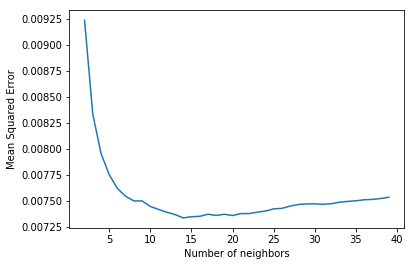

In [24]:
# Plot results from tuning

plt.plot(neighbors, accuracy)
plt.xlabel('Number of neighbors')
plt.ylabel('Mean Squared Error')
print('The optimal number of neighbors is {}'.format(neighbors[np.argmin(accuracy)]))

Mean Squared Error is 0.007338443271028813


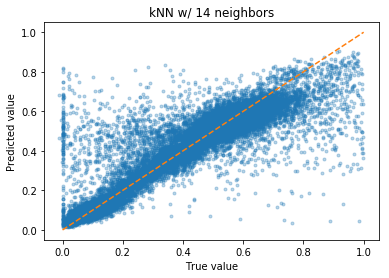

In [27]:
# Re-run for the optimal

knn10 = KNeighborsRegressor(n_neighbors=14)
knn10.fit(X_train, y_train) 
y_pr = knn10.predict(X_test)
mse = mean_squared_error(y_test, y_pr)


plt.plot(y_test, y_pr, '.', alpha = 0.3)
plt.plot([0,1],[0,1], '--')
plt.xlabel('True value')
plt.ylabel('Predicted value')
plt.title('kNN w/ 14 neighbors')
plt.plot()
print('Mean Squared Error is {}'.format(mse))

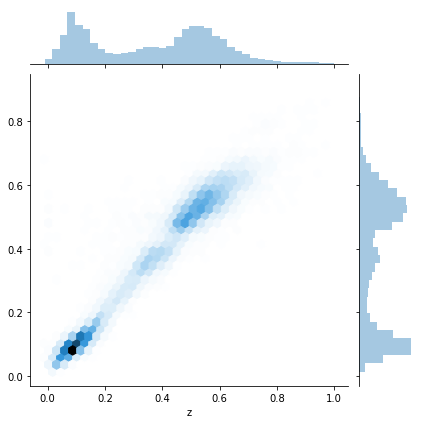

In [26]:
sns.jointplot(y_test, y_pr, kind="hex")

Text(0.5, 1.0, 'Histogram Log Scale')

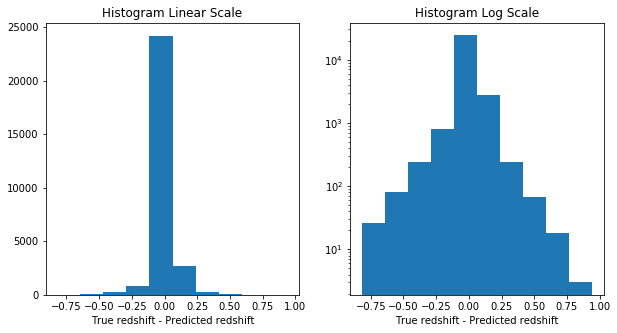

In [30]:
fig, ax = plt.subplots(figsize = (10,5), ncols = 2)

ax[0].hist(y_test - y_pr)
ax[0].set_xlabel('True redshift - Predicted redshift')
ax[0].set_title('Histogram Linear Scale')

ax[1].hist(y_test - y_pr)
ax[1].set_yscale('log')
ax[1].set_xlabel('True redshift - Predicted redshift')
ax[1].set_title('Histogram Log Scale')

There are a lot of things we could try to improve this regressor. For one, we could always implement some kind of data augmentation to improve our covering of the redshift range (by using simulated data with some gaussian processing, etc).

We also didnt look at the features themselves. Do we have photometry in all bands for all the objects??? 

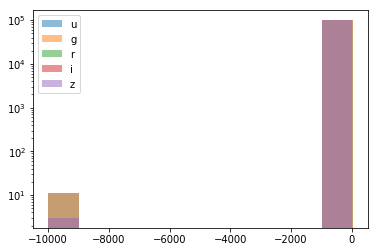

In [44]:
# Simple test

plt.hist(phot_z['modelMag_u'], alpha = 0.5, label = 'u')
plt.hist(phot_z['modelMag_g'], alpha = 0.5, label = 'g')
plt.hist(phot_z['modelMag_r'], alpha = 0.5, label = 'r')
plt.hist(phot_z['modelMag_i'], alpha = 0.5, label = 'i')
plt.hist(phot_z['modelMag_z'], alpha = 0.5, label = 'z')

plt.yscale('log')
plt.legend()

In [45]:
bands = ['u', 'g', 'r', 'i', 'z']

for band in bands:
    print('The amount of sources in band {} with no observations is: {}'.format(band,
                            len(phot_z[phot_z['modelMag_{}'.format(band)] == -9999])))



The amount of sources in band u with no observations is: 11
The amount of sources in band g with no observations is: 11
The amount of sources in band r with no observations is: 0
The amount of sources in band i with no observations is: 0
The amount of sources in band z with no observations is: 3


There could be other issues with the photometry, or we could try using a different regressor. We also haven't separated the galaxies form the quasars, which could be another source of confussion for the model.